# 3. Running on IBM Q

Author : [Gwonhak Lee](https://github.com/snow0369) (gwonhak@gmail.com)

-----
 다음으로 IBM의 양자컴퓨터를 활용하는 방법에 대해 살펴보겠습니다.

### 0. 필요한 요소 불러오기

In [14]:
from qiskit import IBMQ, QuantumRegister, QuantumCircuit, ClassicalRegister, transpile
from qiskit.tools import backend_overview, backend_monitor
from qiskit.providers.ibmq.job import job_monitor
from qiskit.quantum_info import hellinger_fidelity
from qiskit.providers.ibmq import IBMQAccountCredentialsNotFound
from qiskit.providers.aer import AerProvider
from qiskit.tools.visualization import plot_gate_map, plot_histogram

### 1. QPU Backend 확인

IBMQ의 계정을 활성화합니다.

1. IBMQ 홈페이지[(https://quantum-computing.ibm.com/)](https://quantum-computing.ibm.com/)에 로그인합니다.
2. 좌측 상단의 계정 아이콘 -> Account Details 를 클릭합니다.
3. 좌측 중앙에 Copy Token 버튼을 클릭하여 아래 Block의 token 변수에 string 형태로 입력합니다.

In [15]:
token = 'f5876d2c6ea00ce4cefe8fcf6324956e042cd2a7cd57f6efc1e7ba38727964f10cef560830337f64c1de3743c420c1b23ded52bc01b197c6d8ce96394f13f1e0'# Input token here
try:
    IBMQ.disable_account()
except IBMQAccountCredentialsNotFound:
    pass
IBMQ.enable_account(token)

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

활용할 수 있는 backend의 목록을 확인합니다.

In [16]:
backend_overview()

ibmq_manila                  ibmq_quito                   ibmq_belem
-----------                  ----------                   ----------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 4              Pending Jobs: 95             Pending Jobs: 76
Least busy:   False          Least busy:   False          Least busy:   False
Operational:  True           Operational:  True           Operational:  True
Avg. T1:      163.6          Avg. T1:      89.8           Avg. T1:      88.7
Avg. T2:      58.3           Avg. T2:      109.8          Avg. T2:      108.8



ibmq_lima                    ibmq_bogota                  ibmq_santiago
---------                    -----------                  -------------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 0              Pending Jobs: 1              Pending Jobs: 101
Least busy:   True           Least busy:   False          Least busy:   False
Operational:  True          

특정한 qpu backend의 자세한 사항을 확인할 수 있습니다.

아래 예시에서는 `ibmq_manila` 의 특성을 확인합니다.

In [17]:
IBMQ_provider = IBMQ.get_provider()
ibmq_manila_backend = IBMQ_provider.get_backend('ibmq_manila')
backend_monitor(ibmq_manila_backend)

ibmq_manila
Configuration
-------------
    n_qubits: 5
    operational: True
    status_msg: active
    pending_jobs: 4
    backend_version: 1.0.5
    basis_gates: ['id', 'rz', 'sx', 'x', 'cx', 'reset']
    local: False
    simulator: False
    quantum_volume: 32
    credits_required: True
    sample_name: family: Falcon, revision: 5.11, segment: L
    input_allowed: ['job']
    pulse_num_channels: 9
    memory: True
    meas_levels: [1, 2]
    qubit_lo_range: [[4.46277998307546, 5.46277998307546], [4.338419511638877, 5.338419511638877], [4.536938824727899, 5.536938824727899], [4.45130087049468, 5.45130087049468], [4.566354311434293, 5.566354311434293]]
    u_channel_lo: [[{'q': 1, 'scale': (1+0j)}], [{'q': 0, 'scale': (1+0j)}], [{'q': 2, 'scale': (1+0j)}], [{'q': 1, 'scale': (1+0j)}], [{'q': 3, 'scale': (1+0j)}], [{'q': 2, 'scale': (1+0j)}], [{'q': 4, 'scale': (1+0j)}], [{'q': 3, 'scale': (1+0j)}]]
    description: 5 qubit device
    conditional: False
    url: None
    default_rep_d

IBM의 Superconducting QPU는 CNOT 게이트를 적용할 수 있는 qubit pair (Connectivity)가 제한되어 있습니다.
`ibmq_manila`는 다음과 같은 linear connectivity를 가지고 있습니다.

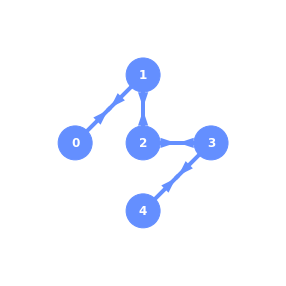

In [18]:
plot_gate_map(ibmq_manila_backend, plot_directed=True)

### 2. QPU Backend 사용하기 및 회로 최적화

3 qubit ghz상태를 준비하여 측정하는 회로를 구성하여 qpu backend를 사용해보겠습니다.

  $$ |GHZ_3\rangle = \frac{1}{\sqrt{2}} (|000\rangle + |111\rangle) $$


먼저 회로를 구현합니다.

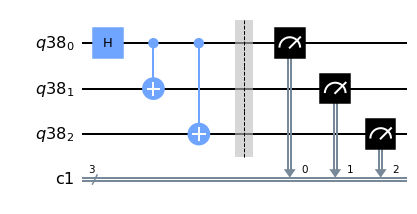

In [19]:
qr = QuantumRegister(3)
cr = ClassicalRegister(3)
ghz3 = QuantumCircuit(qr, cr)
ghz3.h(qr[0])
ghz3.cx(qr[0], qr[1])
ghz3.cx(qr[0], qr[2])
ghz3.barrier()
ghz3.measure(qr, cr)

ghz3.draw('mpl')

주어진 회로를 ibmq_manila_backend 를 통해 실행합니다.

In [20]:
job_exp = ibmq_manila_backend.run(ghz3, shots=2048)
job_monitor(job_exp) # An error must be raised here.

Job Status: ERROR - The Qobj uses gates (['h']) that are not among the basis gates (['id', 'rz', 'sx', 'x', 'cx', 'reset']). Error code: 1106.


여기서, 에러 메세지가 출력될 것입니다. 그 이유는 manila qpu에서 Hadamard gate를 구현할 수 없기 때문입니다.
qpu에서 물리적으로 구현 가능한 basis gate는 다음과 같이 확인할 수 있습니다.

In [21]:
print(ibmq_manila_backend.configuration().basis_gates)

['id', 'rz', 'sx', 'x', 'cx', 'reset']


주어진 회로를 manila backend의 특성에 맞도록 변환하기 위해 transpile 과정을 거칩니다.
hadamard gate가 manila backend에서 제공하는 basis gate들로 변환되었음을 확인할 수 있습니다.
또한 connectivity에 맞게 SWAP operation이 적용되었음을 확인할 수 있습니다.

transpile 과정에서 기본적으로 제공되는 과정은 다음과 같습니다.
- Physical Qubit Layout (Connectivity)에 맞게 virtual to physical Qubit mapping
- 회로의 모든 gate들을 Basis gate set으로 구현
- 측정 gate 전에 barrier 삽입
- Qubit mapping에 맞도록 SWAP gate 생성
- SWAP gate를 3개의 CNOT gate로 분해
- CNOT-CNOT 상쇄
- Single qubit gate 최적화

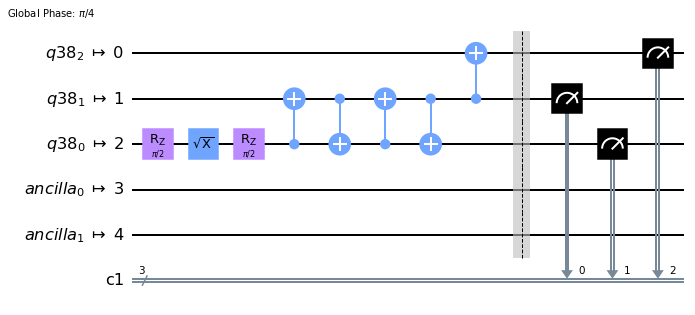

In [22]:
transpiled_circuit = transpile(ghz3, backend=ibmq_manila_backend)
transpiled_circuit.draw('mpl')

기본 transpile 과정을 거친 회로를 비교하면 다음과 같이 H gate가 basis gate로 decompose 되었음을 확인할 수 있고, qubit connectivity에 맞게
qubit에 SWAP 연산이 적용됨을 확인할 수 있습니다.

![transpile](https://github.com/snow0369/qiskit_tutorial_2021_summerschool/raw/master/figures/transpile.png)


변환된 회로에서 여기서 0번째 qubit을 중앙으로 옮긴다면 불필요한 SWAP gate를 줄일 수 있음을 확인할 수 있습니다.
이는 `transpile`에 `optimization_level`옵션을 추가하여 자동으로 수행할 수 있습니다.

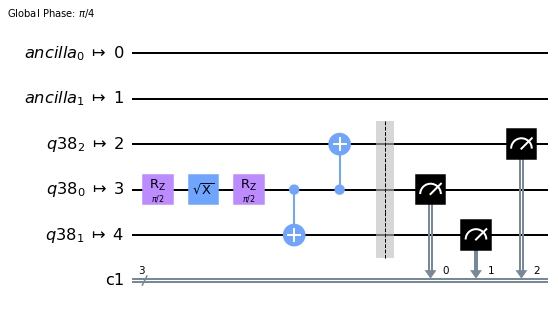

In [23]:
transpiled_circuit_opt = transpile(ghz3, backend=ibmq_manila_backend, optimization_level=3)
transpiled_circuit_opt.draw('mpl')

`optimization_level`은 0 ~ 3의 정수를 입력할 수 있으며, 각 단계마다 다음의 회로 최적화 기능이 추가됩니다.
- 0단계 : 최적화 수행하지 않음
- 1단계(기본) : 이웃한 게이트만 소거
- 2단계 : Noise-adaptive qubit mapping, Gate cancellation using commutativity
- 3단계 : Heavier noise-adaptive qubit mapping, Gate cancellation using commutativity and unitary synthesis.

이제 주어진 회로를 QPU에서 실행하고 결과를 확인합니다.

In [24]:
job_exp = ibmq_manila_backend.run(transpiled_circuit_opt, shots=2048)
job_monitor(job_exp)

Job Status: job has successfully run                       


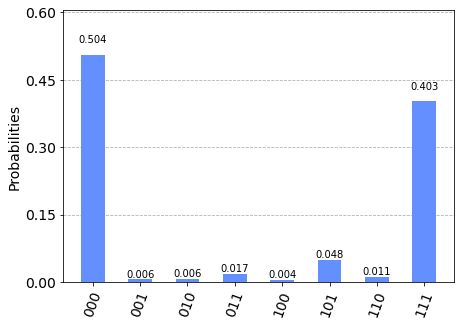

In [25]:
noisy_counts = job_exp.result().get_counts()
plot_histogram(noisy_counts)

Ideal simulation을 수행하고, fidelity를 확인합니다.

In [26]:
qasm_backend = AerProvider().get_backend('qasm_simulator')
job_ideal = qasm_backend.run(ghz3, shots=2048)
ideal_counts = job_ideal.result().get_counts()

print(hellinger_fidelity(noisy_counts, ideal_counts))

0.9023008480548862


### 3. Fake Backend 사용하기
Fake backend를 활용하면 IBM QPU의 특성 및 노이즈 모델 등에 대한 정보를 불러와 시뮬레이션을 수행 할 수 있습니다.
ibmq_rome QPU에 해당하는 fake backend를 불러옵니다.

In [30]:
from qiskit.test.mock import FakeRome

fake_rome = FakeRome()

ghz3 회로를 fake_rome에서 실행합니다. 이상적인 결과에 비해 노이즈가 있음을 확인할 수 있습니다.

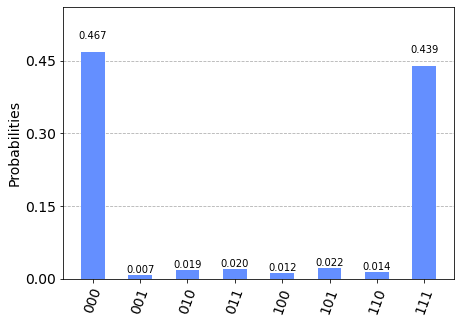

In [28]:
rome_transpiled = transpile(ghz3, backend=fake_rome, optimization_level=3)
job_fake_rome = fake_rome.run(rome_transpiled, shots=2048)
counts_fake_rome = job_fake_rome.result().get_counts()
plot_histogram(counts_fake_rome)